In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.init as nninit
import torch.onnx

## Creating pixels with a neural net


In [7]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.ln1 = nn.Linear(z_size + 3,32,bias=False)  # set the input size according to z_size
        self.ln2 = nn.Linear(32,32,bias=False)
        self.ln3 = nn.Linear(32,32,bias=False)
        self.ln4 = nn.Linear(32,3,bias=False)           # output size is 3 for RGB images
        nninit.uniform_(self.ln1.weight, a=-1,b=1)
        nninit.uniform_(self.ln2.weight,a=-1,b=1)
        nninit.uniform_(self.ln3.weight,a=-1,b=1)
        nninit.uniform_(self.ln4.weight,a=-1,b=1)
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        U = self.ln1(x)
        U = self.tanh1(U)
        U = self.ln2(U)
        U = self.tanh2(U)
        U = self.ln3(U)
        U = self.tanh3(U)
        U = self.ln4(U)
        return self.sigmoid(U)

## Define variables for the image creation ##

In [8]:
height = 200
width = 200
scale = 0.1
z_size = 7  
num_images = 10
alpha = 1  # constant for shifting vector z

model_dir = 'models/'
base_name = "images/"
model_name = 'arts_model'
pytorch_ending = ".pt"
onnx_ending = ".onnx"

In [9]:
def createInputVec(z,x,y):
    r = math.sqrt(((x*scale-(x*scale/2))**2) + ((y*scale-(y*scale/2))**2) )
    z_size = len(z)
    input = torch.rand(1,z_size + 3)
    
    for i in range(z_size):
        input[0][i] = z[i] * scale
        
    input[0][z_size] = x * scale
    input[0][z_size+1] = y * scale
    input[0][z_size+2] = r
    input = Variable(input)
    return input

In [10]:
def update_z(z, alpha=1):
    for i in range (len(z)):
        z[i] = z[i] + alpha
    return z

Image no. 1
images/arts_model_1.png


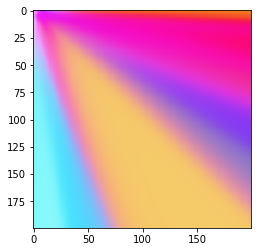

Image no. 2
images/arts_model_2.png


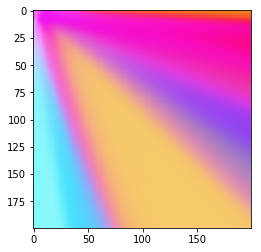

Image no. 3
images/arts_model_3.png


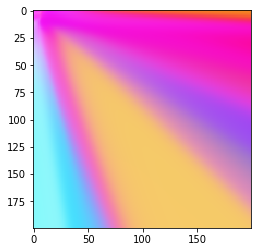

Image no. 4
images/arts_model_4.png


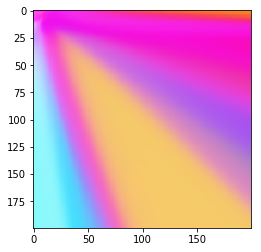

Image no. 5
images/arts_model_5.png


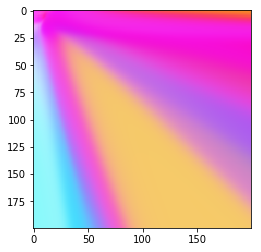

Image no. 6
images/arts_model_6.png


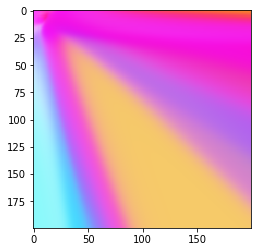

Image no. 7
images/arts_model_7.png


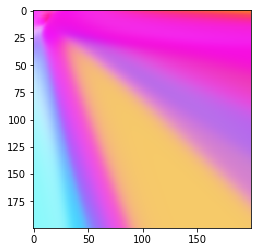

Image no. 8
images/arts_model_8.png


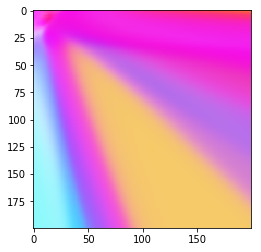

Image no. 9
images/arts_model_9.png


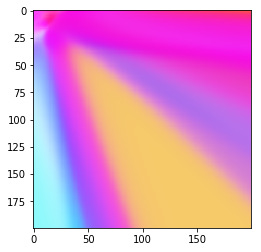

Image no. 10
images/arts_model_10.png


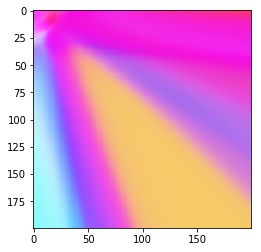

In [11]:
G = net()
#batch produce
z = torch.rand(z_size)
for i in range(num_images):
    print("Image no. "+str(i+1))

    update_z(z, alpha)
     
    #image = np.zeros((img_size ** 2, 1)) # gray scale version
    #image = np.zeros((img_size ** 2, 3)) # colour version
    image = np.zeros((height * width, 3)) # colour version
    for h in range(height):
        
        for w in range(width):
            input = createInputVec(z,h,w)
            image[h * width + w] = G(input).data.numpy()

    #image = np.stack((image,image,image), axis=1)
    #image = image.reshape(img_size,img_size) # gray scale version

    image = image.reshape(height, width,3) # gray scale version
    image_name = base_name + model_name + "_" + str(i+1)+ ".png"
    print(image_name)

    imgplot = plt.imshow(image)#, cmap='gray')    # cmap was missing and displaying grayscale images as "coloured"
    plt.show()
    plt.imsave(image_name, image)


## Save pytorch and ONNX models ##

In [12]:
# save pytorch model
torch.save(G, model_dir + model_name + pytorch_ending)

# save onnx model
dummy_input = torch.randn(1, z_size + 3)                               # same size as input.shape
torch.onnx.export(G, dummy_input, model_dir + model_name + onnx_ending)

C:\Users\susbr\AppData\Local\Continuum\anaconda3\envs\openVINO\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Converting the model to Intermediate Represenetation (IR)
Go to ```<INSTALL_DIR>/deployment_tools/model_optimizer``` directory and run the mo.py file.<br/>
```python3 mo.py --input_model <path to model>.onnx```


In [31]:
%run "C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo.py" --input_model models/arts_model.onnx -o models/